In [1]:
import torch
import json
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from models import Net
from torchvision.transforms import Lambda, Compose, ToTensor, Normalize
from PIL import Image, ImageOps, ImageFilter

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# 감정별 이미지 데이터셋 클래스 정의
class EmotionImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('jpg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [4]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터 로더 설정
emotion_paths = {
    'Angry': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Angry',
    'Disgusted': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Disgusted',
    'Happy': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Happy',
    'Normal': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Normal',
    'Sad': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Sad',
    'Scared': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Scared',
    'Surprised': '/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Surprised',
}

data_loaders = {
    emotion: DataLoader(EmotionImageDataset(path, transform=transform), batch_size=10, shuffle=False)
    for emotion, path in emotion_paths.items()
}

In [5]:
#device = torch.device("cpu")
#print("Using device:", device)

In [6]:
# 모델 로드
device = torch.device("cpu")
model = Net().to(device)
model_path = '/home/work/XAI/BITAmin/facial/models/cat_keypoints_model5.pt'
model.load_state_dict(torch.load(model_path))
model.eval()


Net(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [7]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """ 이미지 위에 키포인트를 시각화합니다.
    Args:
        image (numpy.array): 시각화할 이미지
        predicted_key_pts (numpy.array): 예측된 키포인트
        gt_pts (numpy.array, optional): 실제 키포인트 (기본값: None)
    """
    plt.imshow(image)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

def visualize_output(images, outputs, gt_pts=None, batch_size=4):
    """ 예측된 키포인트와 원본 이미지를 시각화합니다.
    Args:
        images (torch.Tensor): 모델에 입력된 이미지
        outputs (torch.Tensor): 모델이 예측한 키포인트
        gt_pts (torch.Tensor, optional): 실제 키포인트 (기본값: None)
        batch_size (int): 시각화할 이미지 수
    """
    # 정규화에 사용된 평균 및 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(1, batch_size, i + 1)
        image = images[i].cpu().data.numpy()
        image = np.transpose(image, (1, 2, 0))  # 채널을 마지막 차원으로 이동

        # 정규화를 취소하여 원본 색상으로 복원
        image = std * image + mean
        image = np.clip(image, 0, 1)  # 값이 [0, 1] 범위를 넘지 않도록 클리핑
        
        predicted_key_pts = outputs[i].cpu().data.numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100  # 스케일 조정
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu().data.numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis('off')
    plt.show()

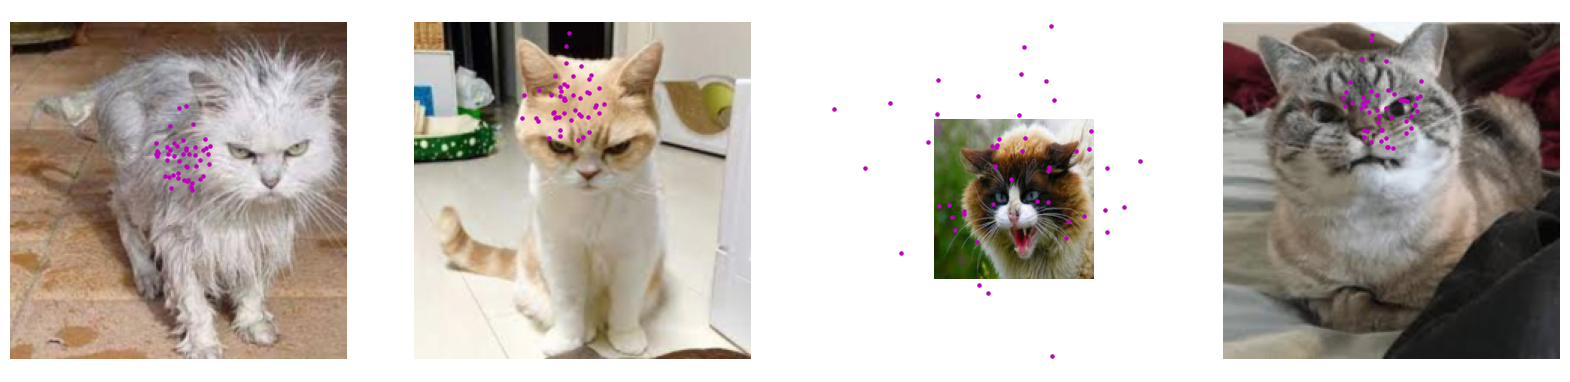

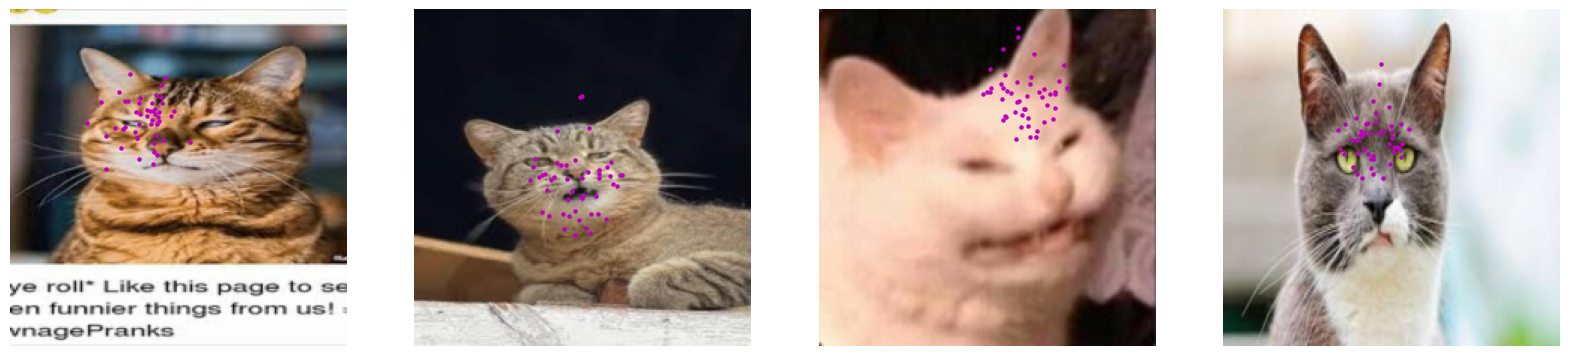

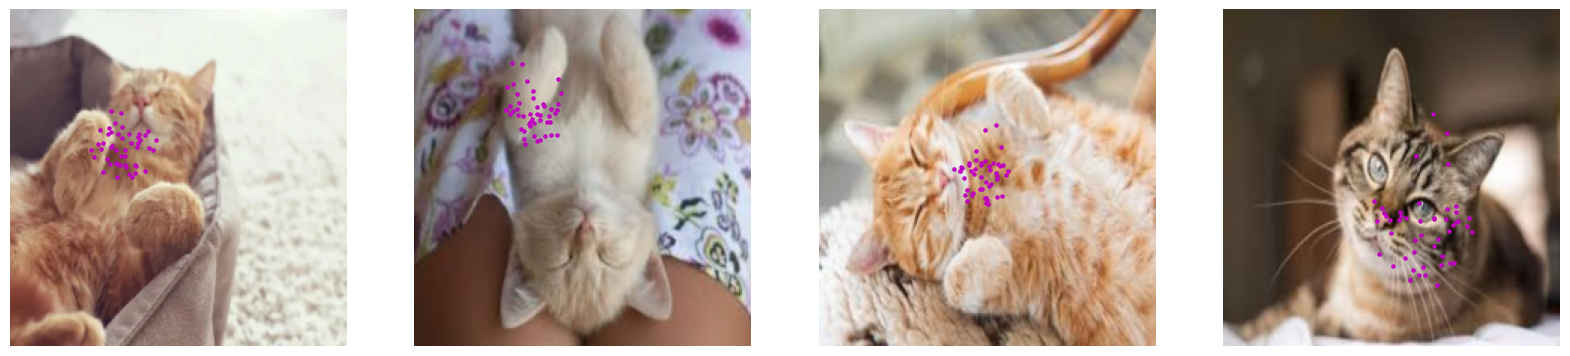

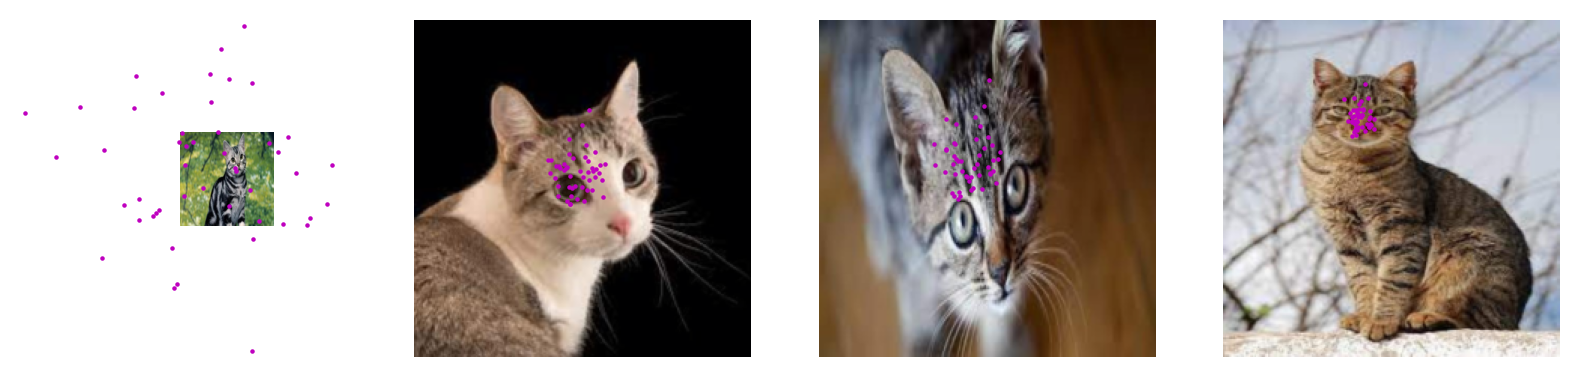

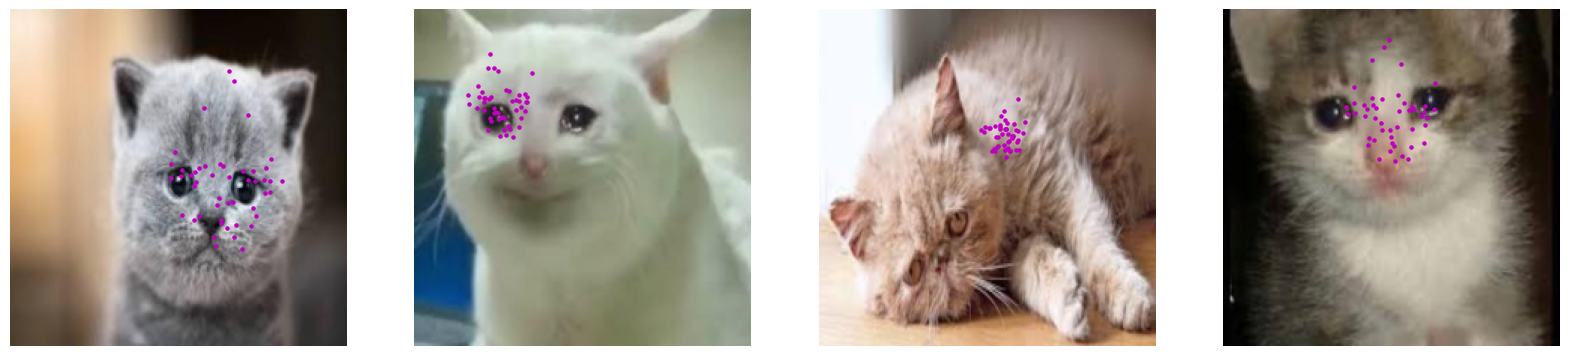

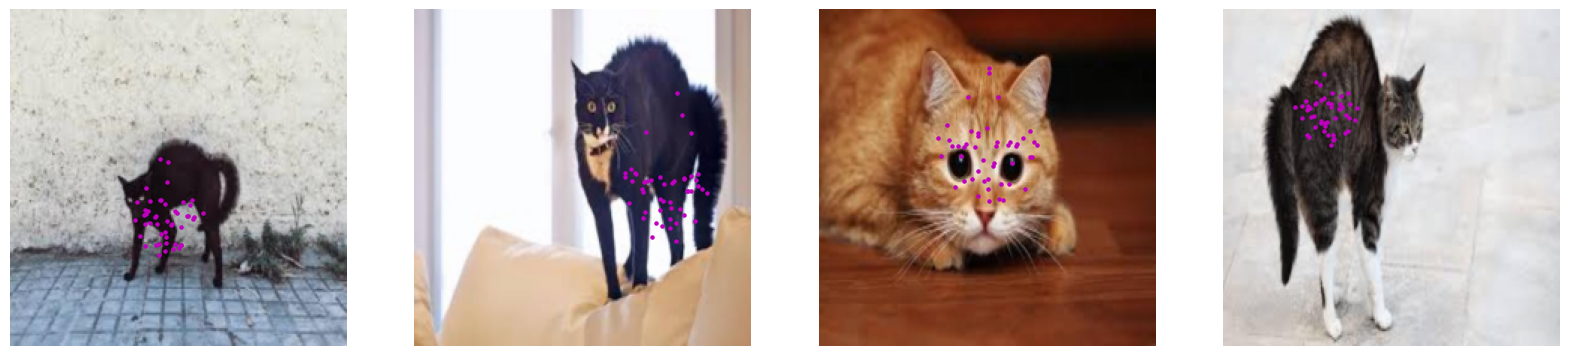

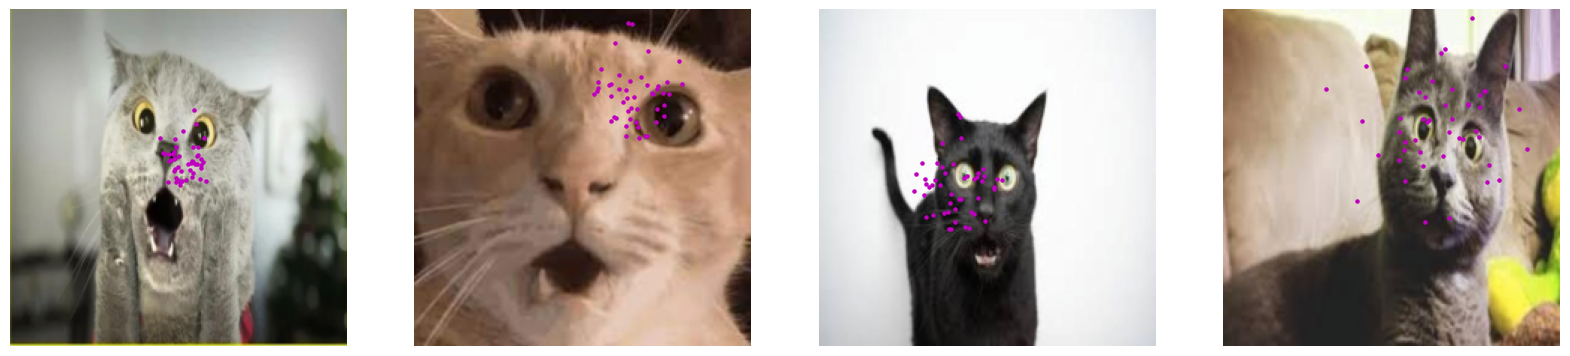

In [8]:
import numpy as np 
# 예시로 시각화하기
for emotion in data_loaders:
    for images in data_loaders[emotion]:
        outputs = model(images.to(device))
        outputs = outputs.view(outputs.size(0), 48, 2)
        visualize_output(images, outputs)
        break  # 첫 배치만 시각화

In [9]:
import numpy as np


for emotion, loader in data_loaders.items():
    with torch.no_grad():
        for images, paths in loader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1, 2)  # 224x224 기준으로 예측된 키포인트

            outputs = outputs.cpu().numpy()

            for idx, output in enumerate(outputs):
                image = images[idx]
                path = paths[idx]
                keypoints = output
                image = image.permute(1, 2, 0).cpu().numpy()

                # 정규화 해제 (정규화된 이미지를 원래대로 돌리기 위해)
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                image = np.clip(image, 0, 1)  # 값의 범위를 0과 1 사이로 제한

                plt.imshow(image)
                plt.scatter(keypoints[:, 0], keypoints[:, 1], color='red', s=10)
                plt.title(f'{emotion} - Keypoints Prediction')
                plt.axis('off')
                plt.show()

                # 키포인트 결과 저장
                keypoints_dict = {'image_path': path, 'keypoints': keypoints.tolist()}
                keypoints_results.append(keypoints_dict)


ValueError: too many values to unpack (expected 2)

In [ ]:
# 인퍼런스 실행 및 시각화, JSON 추출
keypoints_results = []

for emotion, loader in data_loaders.items():
    with torch.no_grad():
        for images, paths, scale_widths, scale_heights in loader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1, 2) * 224

            outputs = outputs.cpu().numpy()

            for idx, (image, path, scale_width, scale_height) in enumerate(zip(images, paths, scale_widths, scale_heights)):
                keypoints = outputs[idx]
                keypoints[:, 0] *= scale_width.numpy()  # Tensor를 NumPy로 변환
                keypoints[:, 1] *= scale_height.numpy()  # Tensor를 NumPy로 변환
                image = image.permute(1, 2, 0).cpu().numpy()
                image = (image * 0.224 + 0.456)  # Un-normalize the image

                plt.imshow(image)
                plt.scatter(keypoints[:, 0], keypoints[:, 1], color='red', s=10)
                plt.title(f'{emotion} - Keypoints Prediction')
                plt.axis('off')
                plt.show()

                # Save keypoints to JSON
                keypoints_dict = {
                    'image_path': path,
                    'keypoints': keypoints.tolist()
                }
                keypoints_results.append(keypoints_dict)


In [ ]:

# JSON 파일로 저장
json_filename = 'keypoints_predictions.json'
with open(json_filename, 'w') as f:
    json.dump(keypoints_results, f, indent=4)

print(f"JSON file '{json_filename}' has been saved with keypoints data.")